## Лабораторная работа по курсу "Искусственный интеллект"

| Студент | Дубов А.В. |
|---------|-------------|
| Группа  | М8О-308Б-18 |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [4]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  2557k      0  0:00:03  0:00:03 --:--:-- 2557k
gzip: mnist.pkl already exists; do you wish to overwrite (y or n)? ^C


In [44]:
import pickle
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random

Загружаем датасет:

In [24]:
with open('mnist.pkl', 'rb') as f:
    MNIST = pickle.load(f)

# Нормируем признаки. Т.о. признак представляет собой яркость от 0 до 1
data = MNIST['Train']['Features'].astype(np.float32) / 256.
labels = MNIST['Train']['Labels']

Смотрим на то, какие данные получились:

In [25]:
data.shape

(42000, 784)

Разбиваем датасет на обучающую и тестовую выборки:

In [26]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=24)

In [27]:
class Linear:
    
    def __init__(self, nin, nout):
        self.W = np.random.normal(0., 1. / np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1, nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b) 
        
    
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db
        

In [28]:
class Softmax:
    
    def forward(self, z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis=1, keepdims=True)
        return expz / Z
    
    
    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
        

In [29]:
class CrossEntropyLoss:
    
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    
    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1. / len(self.y)
        return dlog_softmax / self.p
    

In [30]:
class Tanh:
    
    def forward(self, x):
        self.y = np.tanh(x)
        return self.y
    
    
    def backward(self, dy):
        return (1. - self.y ** 2) * dy


In [31]:
class Net:
    
    def __init__(self, loss_func=CrossEntropyLoss()):
        self.layers = []
        self.loss_func = loss_func
        
    
    def add(self,l):
        self.layers.append(l)
        
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    
    def update(self,lr):
        for l in self.layers[::-1]:
            if 'update' in l.__dir__():
                l.update(lr)
    
    
    def one_epoch(self, x, y, batch_size=4, lr=0.1):
        for i in range(0, len(x), batch_size):
            xb = x[i:i + batch_size]
            yb = y[i:i + batch_size]
            
            # forward pass
            p = self.forward(xb)
            loss = self.loss_func.forward(p, yb)
            
            # backward pass
            dp = self.loss_func.backward(loss)
            dx = self.backward(dp)
            self.update(lr)
                
    
    def train(self, x_train, y_train, n_epochs=30, batch_size=4, lr=0.1, add_report=False, 
              x_test=None, y_test=None):
        if add_report and x_test is not None and y_test is not None:
            reports = [[(self.get_accuracy(x_train, y_train), 
                         self.get_loss(x_train, y_train)),
                        (self.get_accuracy(x_test, y_test),
                         self.get_loss(x_test, y_test))]]
            
        for _ in range(n_epochs):
            self.one_epoch(x_train, y_train, batch_size, lr)
            if add_report and x_test is not None and y_test is not None:
                reports.append([(self.get_accuracy(x_train, y_train), 
                                 self.get_loss(x_train, y_train)),
                                (self.get_accuracy(x_test, y_test),
                                 self.get_loss(x_test, y_test))])
                
        if add_report and x_test is not None and y_test is not None:
            return reports
    
    
    def predict(self, x):
        return np.argmax(self.forward(x),axis=1) 
    
    
    def get_accuracy(self, x, y):
        pred = self.predict(x)
        return (pred == y).mean()
    
    
    def get_loss(self, x, y):
        p = self.forward(x)
        return self.loss_func.forward(p, y)
        

In [60]:
def plot_train(reports):
    x = [i for i in range(len(reports))]
    train_accuracy = [report[0][0] for report in reports]
    test_accuracy = [report[1][0] for report in reports]
    train_loss = [report[0][1] for report in reports]
    test_loss = [report[1][1] for report in reports]
    fig, ax = plt.subplots(2, 1)
    plt.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle("Изменение точности и значения функции ошибок")
    ax[0].axis([-1, len(reports) + 1, 0, 1])
    ax[0].plot(x, train_accuracy, color='green', label='accuracy на обучающей выборке')
    ax[0].plot(x, test_accuracy, '--', color='orange', label='accuracy на тестовой выборке')
    ax[0].legend()
    ax[1].plot(x, train_loss, color='green', label='loss на обучающей выборке')
    ax[1].plot(x, test_loss, '--', color='orange', label='loss на тестовой выборке')
    ax[1].legend()
    plt.show()
    

## Однослойный перцептрон

Начальная точность на тестовой выборке: 0.102024
Конечная точность на тестовой выборке: 0.923571
Матрица неточности:


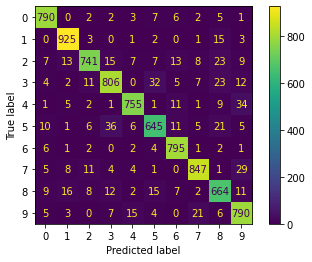

In [46]:
single_perc = Net()
single_perc.add(Linear(784, 10))
single_perc.add(Softmax())
print('Начальная точность на тестовой выборке: {:.6f}'.format(single_perc.get_accuracy(x_test, y_test)))
reports = single_perc.train(x_train, y_train, 35, 4, 0.01, True, x_test, y_test)
print('Конечная точность на тестовой выборке: {:.6f}'.format(single_perc.get_accuracy(x_test, y_test)))
print('Матрица неточности:')
cm = confusion_matrix(y_test, single_perc.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

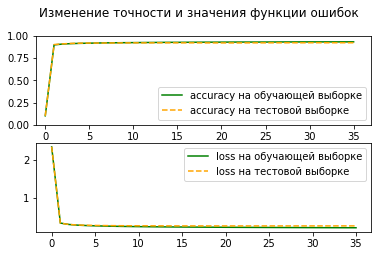

In [47]:
plot_train(reports)

## Двухслойный перцептрон

Начальная точность на тестовой выборке: 0.067381
Конечная точность на тестовой выборке: 0.974524
Матрица неточности:


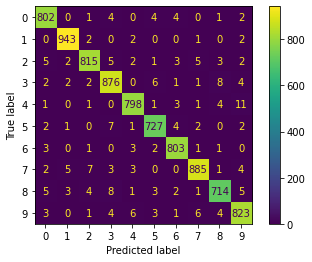

In [48]:
two_perc = Net()
two_perc.add(Linear(784, 128))
two_perc.add(Tanh())
two_perc.add(Linear(128, 10))
two_perc.add(Softmax())
print('Начальная точность на тестовой выборке: {:.6f}'.format(two_perc.get_accuracy(x_test, y_test)))
reports = two_perc.train(x_train, y_train, 35, 4, 0.01, True, x_test, y_test)
print('Конечная точность на тестовой выборке: {:.6f}'.format(two_perc.get_accuracy(x_test, y_test)))
print('Матрица неточности:')
cm = confusion_matrix(y_test, two_perc.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

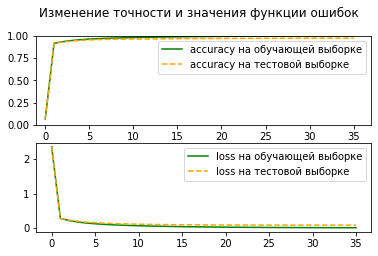

In [49]:
plot_train(reports)

## Трехслойный перцептрон

Начальная точность на тестовой выборке: 0.106548
Конечная точность на тестовой выборке: 0.975833
Матрица неточности:


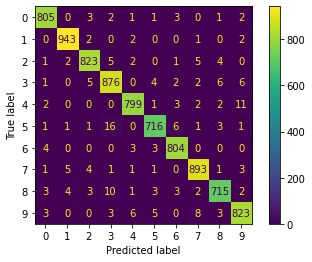

In [53]:
three_perc = Net()
three_perc.add(Linear(784, 256))
three_perc.add(Tanh())
three_perc.add(Linear(256, 128))
three_perc.add(Tanh())
three_perc.add(Linear(128, 10))
three_perc.add(Softmax())
print('Начальная точность на тестовой выборке: {:.6f}'.format(three_perc.get_accuracy(x_test, y_test)))
reports = three_perc.train(x_train, y_train, 35, 4, 0.01, True, x_test, y_test)
print('Конечная точность на тестовой выборке: {:.6f}'.format(three_perc.get_accuracy(x_test, y_test)))
print('Матрица неточности:')
cm = confusion_matrix(y_test, three_perc.predict(x_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 

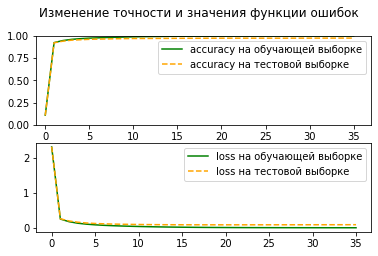

In [54]:
plot_train(reports)

## Другие передаточные функции

* Тождественная функция $f(x) = x, f'(x) = 1$

In [55]:
class Identity:
    
    def forward(self, x):
        return x
    
    
    def backward(self, dy):
        return dy


* Сигмоида $f(x) = \frac{1}{1 + e^{-x}}, f'(x) = f(x)\cdot(1 - f(x))$

In [56]:
class Sigmoid:
    
    def forward(self, x):
        self.y = 1. / (1. + np.exp(-x))
        return self.y
    
    
    def backward(self, dy):
        return self.y * (1. - self.y) * dy
    

* Полулинейная функция $f(x) = \left\{
  \begin{array}{cc}
    0 & x \le 0 \\
    x & x > 0 \\
  \end{array}
\right.$, $f'(x) = \left\{
  \begin{array}{cc}
    0 & x \le 0 \\
    1 & x > 0 \\
  \end{array}
\right.$

In [66]:
class ReLU:
    
    def forward(self, x):
        self.g = x > 0
        return x * self.g
    
    
    def backward(self, dy):
        return dy * self.g
    

## Сравнение передаточных функций

Сравнение будем проводить для двухслойного персептрона

Начальная точность Tanh на тестовой выборке: 0.078571
Конечная точность Tanh на тестовой выборке: 0.972619


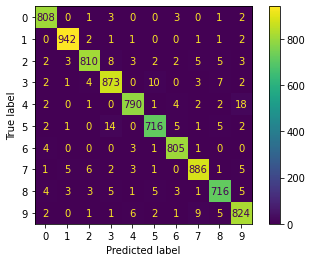

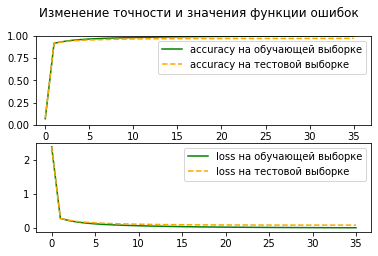

Начальная точность Identity на тестовой выборке: 0.100833
Конечная точность Identity на тестовой выборке: 0.917619


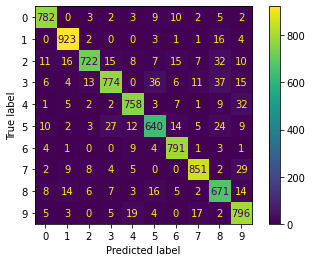

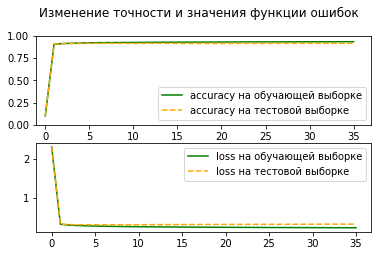

Начальная точность Sigmoid на тестовой выборке: 0.096905
Конечная точность Sigmoid на тестовой выборке: 0.963810


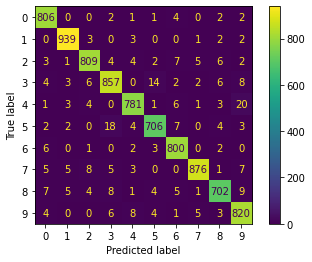

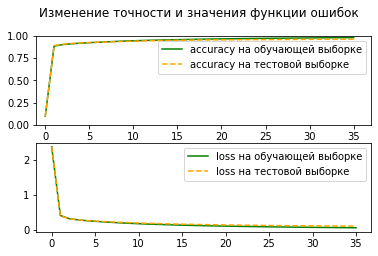

Начальная точность ReLU на тестовой выборке: 0.058810
Конечная точность ReLU на тестовой выборке: 0.974762


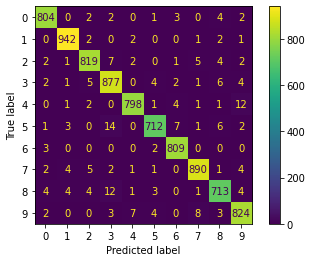

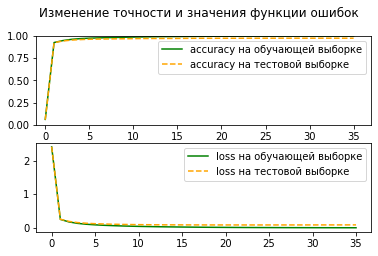

In [68]:
for function in [Tanh, Identity, Sigmoid, ReLU]:
    perc = Net()
    perc.add(Linear(784, 128))
    perc.add(function())
    perc.add(Linear(128, 10))
    perc.add(Softmax())
    print('Начальная точность {} на тестовой выборке: {:.6f}'.format(function.__name__,
                                                                     perc.get_accuracy(x_test, y_test)))
    reports = perc.train(x_train, y_train, 35, 4, 0.01, True, x_test, y_test)
    print('Конечная точность {} на тестовой выборке: {:.6f}'.format(function.__name__,
                                                                    perc.get_accuracy(x_test, y_test)))
    cm = confusion_matrix(y_test, perc.predict(x_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 
    plot_train(reports)

## Сравнение результатов работы двухслойного персептрона при различных значениях количества нейронов в промежуточных слоях

Исследуется двухслойный перспетрон, в котором промежуточная функция - гиперболический тангенс, функция ошибок - cross entropy loss. Количество эпох 15.

In [70]:
for n_neurons in range(2, 255, 4):
    perc = Net()
    perc.add(Linear(784, n_neurons))
    perc.add(Tanh())
    perc.add(Linear(n_neurons, 10))
    perc.add(Softmax())
    perc.train(x_train, y_train, 15, 4, 0.1)
    print('Точность на тестовой выборке при {} нейронах в промежуточном слое: {:.6f}'
          .format(n_neurons, perc.get_accuracy(x_test, y_test)))

Точность на тестовой выборке при 2 нейронах в промежуточном слое: 0.388452
Точность на тестовой выборке при 6 нейронах в промежуточном слое: 0.883571
Точность на тестовой выборке при 10 нейронах в промежуточном слое: 0.908095
Точность на тестовой выборке при 14 нейронах в промежуточном слое: 0.928690
Точность на тестовой выборке при 18 нейронах в промежуточном слое: 0.925119
Точность на тестовой выборке при 22 нейронах в промежуточном слое: 0.941190
Точность на тестовой выборке при 26 нейронах в промежуточном слое: 0.940476
Точность на тестовой выборке при 30 нейронах в промежуточном слое: 0.948452
Точность на тестовой выборке при 34 нейронах в промежуточном слое: 0.951071
Точность на тестовой выборке при 38 нейронах в промежуточном слое: 0.957381
Точность на тестовой выборке при 42 нейронах в промежуточном слое: 0.952500
Точность на тестовой выборке при 46 нейронах в промежуточном слое: 0.962262
Точность на тестовой выборке при 50 нейронах в промежуточном слое: 0.955714
Точность на те